# Libraries and DataSet

In [1]:
#import all the necessary libraries
import networkx as nx
import numpy as np
import pandas as pd
import random
import networkx.algorithms.community as nx_comm
from sklearn.metrics.cluster import normalized_mutual_info_score
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
print("Libraries successfully imported")

G = nx.read_gml('dolphins.gml', label='id',destringizer=int)
nodes = np.array(G.nodes)
edges = np.array(G.edges)
print("Data ready")
graph=nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
adj=nx.adjacency_matrix(graph)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Libraries successfully imported
Data ready


# Non dominating sorting

In [2]:
def cond(clusters_list):
  score = min(nx.conductance(graph, cluster_i) for cluster_i in clusters_list)
  return score;

In [3]:
def nmi(p):
  return normalized_mutual_info_score(true_label_dolphins,p)

In [4]:
def generate_LAR(num_nodes):
    particle=np.array([],dtype = int)
    for x in range(num_nodes):
        rand=np.random.randint(0,num_nodes)
        while adj[x,rand]!=1:
            rand=np.random.randint(0,num_nodes)
        particle=np.append(particle,rand)
    return particle



In [5]:
def conductance(communities, adj_matrix):
    # Calculate the conductance score for the communities
    if len(communities) != 2:
        return 0;
    num_edges = np.sum(adj_matrix[np.ix_(communities[0], communities[1])])
    num_vertices = np.sum(adj_matrix[communities[0]]) + np.sum(adj_matrix[communities[1]])
    conductance = num_edges / num_vertices
    return conductance

In [6]:
def con(dframe):
  o=[]
  for i in range(len(dframe["conductance"])):
    o.append([dframe["conductance"][i],dframe["Modularity"][i]])
  return o
  # n=non_dominated_sorting1(o)
  # m=0
  # s=0
  # for i in n:
  # if(m<dframe["NMI"][i]):
  #   m=dframe["NMI"][i]
  #         s=i
  #     global_best=dframe.loc[dframe.index[s]]
    

In [7]:
def init_pbest(dframe):
  return dframe

In [8]:
def non_dominated_sorting1(population):
    # Calculate the number of individuals that dominate each individual
    domination_count = [0] * len(population)
    for i in range(len(population)):
        for j in range(len(population)):
            if i != j:
                if (population[i][0] < population[j][0] and population[i][1] >= population[j][1] or (population[i][0] == population[j][0] and population[i][1] > population[j][1])):
                    domination_count[j] += 1

    # Identify the first front (non-dominated individuals)
    front = []
    for i in range(len(population)):
        if domination_count[i] == 0:
            front.append(i)

    return front

In [9]:
def two_point_crossover(particle,pbest):
#     print(graph)
    cut_points = np.sort(np.random.choice(len(particle['LAR']), 2, replace=False))
    child1 = {}
    child2 = {}
    child1['LAR'] = np.concatenate((particle['LAR'][:cut_points[0]], pbest[cut_points[0]:cut_points[1]], particle['LAR'][cut_points[1]:]))
    child2['LAR'] = np.concatenate((pbest[:cut_points[0]], particle['LAR'][cut_points[0]:cut_points[1]], pbest[cut_points[1]:]))
    child1['particle'] = kernel_kmeans(child1['LAR'])
    child1['communities'] = find_community(child1['particle'])
    child1['Modularity'] = nx_comm.modularity(graph, child1['communities'])
    child2['particle'] = kernel_kmeans(child2['LAR'])
    child2['communities'] = find_community(child2['particle'])
    child2['Modularity'] = nx_comm.modularity(graph, child2['communities'])
        
    return child1, child2

In [10]:
# def mutate(particle):
#     mutated_particle={}
#     mutated_particle['LAR']=particle['LAR']
#     for _ in range(15):
#         i = np.random.randint(0, len(particle['LAR']))
#         j = np.random.randint(0, len(particle['LAR']))
#         if adj[i,j]==1 :
#             mutated_particle['LAR'][i] = j
#     mutated_particle['particle'] = kernel_kmeans(mutated_particle['LAR'])
#     mutated_particle['communities'] = find_community(mutated_particle['particle'])
#     mutated_particle['Modularity'] = nx_comm.modularity(graph, mutated_particle['communities'])
#     return mutated_particle


In [11]:
def mutate(particle):
    mutated_particle={}
    mutated_particle['LAR']=particle['LAR']
    i = np.random.randint(0, len(particle['LAR']))
    j = np.random.randint(0, len(particle['LAR']))
    while adj[i,j] != 1:
        j = np.random.randint(0, len(particle['LAR']))   
    mutated_particle['LAR'][i] = j
    
    mutated_particle['particle'] = kernel_kmeans(mutated_particle['LAR'])
    mutated_particle['communities'] = find_community(mutated_particle['particle'])
    mutated_particle['Modularity'] = nx_comm.modularity(graph, mutated_particle['communities'])
    return mutated_particle

# Truth label / Ground label

In [12]:
def find_particle2(community):
  arr=[]
  for x in range(len(community)):
    for i in community[x]:
      arr.insert(i-1,x);
  return arr

In [13]:
true_communities_dolphins=[{19,21,22,24,9,12,13,51,30,15,4,16,17,35,34,36,37,38,31,44,43,1,60,56,3,25,41,39,40,29,45,59,11,46,47,48,62,54,52,50,5,53},
               {61,57,6,2,55,8,14,7,49,42,27,33,10,58,23,32,26,28,18,20}]
true_label_dolphins=find_particle2(true_communities_dolphins)

# Functions

In [14]:

def find_community(labels):
  communities = [[] for _ in range(len(np.unique(labels)))]
  # print((communities))
  for i in range(len(labels)):
    # print(labels[i], " ", i)
    communities[labels[i]].append(i)
  return communities

In [15]:


def kernel_kmeans(data, n_comm=2):
    data = np.array(data)
    data = data.reshape(-1, 1)
    n_samples = data.shape[0]
    kernel_matrix = pairwise_kernels(data, data, metric='rbf') # Using Radial basis function kernel
    labels = np.zeros(n_samples)
    
    # Initialize cluster centers randomly
    rand_indices = np.random.choice(n_samples, n_comm, replace=False)
    centers = data[rand_indices, :]
    
    while True:
        # Assign each point to the nearest cluster
        for i in range(n_samples):
            distances = pairwise_kernels(data[i, np.newaxis], centers, metric='rbf')
            labels[i] = np.argmax(distances)
        
        # Compute the new cluster centers
        for j in range(n_comm):
            indices = np.where(labels == j)[0]
            if len(indices) > 0:
                centers[j, :] = np.mean(data[indices, :], axis=0)
        
        # Check for convergence
        new_labels = np.zeros(n_samples)
        for i in range(n_samples):
            distances = pairwise_kernels(data[i, np.newaxis], centers, metric='rbf')
            new_labels[i] = np.argmax(distances)
        if np.array_equal(new_labels, labels):
            break
        else:
            labels = new_labels
    labels = [int(i) for i in labels]

    return labels


# PSO Algorithm


In [37]:
def pso(nodes,edges,population=200,generation=100):
  # Making adjacecny matrix
    print("Ready")
    num_nodes=len(nodes)

    # DataFrame
    d={"LAR":[generate_LAR(num_nodes) for n in range (population)]}
    dframe = pd.DataFrame(data=d)
    dframe["particle"] = dframe.apply(lambda x: kernel_kmeans(x["LAR"]), axis=1)
    dframe["communities"]=dframe["particle"].apply(find_community)
    dframe["Modularity"] = dframe.apply(lambda x: nx_comm.modularity(graph, x["communities"]), axis=1)
    dframe["conductance"]=dframe.apply(lambda x: conductance(x["communities"],adj),axis=1)
#     dframe["conductance"]=(conductance(dframe["particle"],adj))
#     print(dframe)

    dframe["NMI"] = dframe.apply(lambda x: nmi(x["particle"]), axis=1)
    pbest=dframe
    # print(pbest)
    print("Set")
    o=[]
    for i in range(len(dframe["conductance"])):
        o.append([dframe["conductance"][i],dframe["Modularity"][i]])
    pareto_set=non_dominated_sorting1(o)
    m=0
    s=0
    for i in pareto_set:
        if(m<dframe["NMI"][i]):
            m=dframe["NMI"][i]
            s=i
    gbest=dframe.loc[dframe.index[s]]
    
    print("GO")
    for t in range(generation):
        mutated_particle = []
        for i, particle in dframe.iterrows():
            child1, child2 = two_point_crossover(particle, pbest['LAR'][i])
            child1['conductance'] = conductance(child1["communities"],adj)
            child2['conductance'] = conductance(child2["communities"],adj)
        
            mod1, co1 = child1['Modularity'], child1['conductance']
            mod2, co2 = child2['Modularity'], child2['conductance']

            nmi1, nmi2 = nmi(child1['particle']), nmi(child2['particle'])
            if (co1 < co2 and mod1 >= mod2) or (co1 == co2 and mod1 > mod2):
                temp_par = child1
            elif (co2 < co1 and mod2 >= mod1) or (co2 == co1 and mod2 > mod1):
                temp_par = child2
            else:
                temp_par = child1 if nmi1 > nmi2 else child2
        # print(temp_par)

            out1, out2 = two_point_crossover(temp_par, gbest["LAR"])
        
            out1['conductance'] = conductance(out1["communities"],adj)
            out2['conductance'] = conductance(out2["communities"],adj)
        
#         # Calculate the values of the objective functions for the outputs
            mod_out1, co_out1 = out1['Modularity'], out1["conductance"]
            mod_out2, co_out2 = out2['Modularity'], out2["conductance"]
        
#         # Choose the output with the highest NMI score
            nmi_out1, nmi_out2 = nmi(out1['particle']), nmi(out2['particle'])
            if (co_out1 < co_out2 and mod_out1 >= mod_out2) or (co_out1 == co_out2 and mod_out1 > mod_out2):
                pi = out1
            elif (co_out2 < co_out1 and mod_out2 >= mod_out1) or (co_out2 == co_out1 and mod_out2 >mod_out1):
                pi = out2
            else:
                pi = out1 if nmi_out1 > nmi_out2 else out2
#             if nmi_out1 > nmi_out2:
#                 pi = out1
#             elif nmi_out2 > nmi_out1:
#                 pi = out2
#             else:
#                 pi = out1 if mod_out1 > mod_out2 else out2
            mp = mutate(pi)
            mp['conductance'] = conductance(mp['communities'], adj)
            mp['NMI'] = nmi(mp['particle'])
            mutated_particle.append(mp)
            if mp['NMI'] > pbest['NMI'][i]:
#                 pbest[i] = mp
                pbest['LAR'][i] = mp['LAR']
                pbest['particle'][i] = mp['particle']
                pbest['communities'][i] = mp['communities']
                pbest['Modularity'][i] = mp['Modularity']
                pbest['conductance'][i] = mp['conductance']
                pbest['NMI'][i] = mp['NMI']
            dframe['LAR'][i] = mp['LAR']
            dframe['particle'][i] = mp['particle']
            dframe['communities'][i] = mp['communities']
            dframe['Modularity'][i] = mp['Modularity']
            dframe['conductance'][i] = mp['conductance']
            dframe['NMI'][i] = mp['NMI']
            
#         mutated_particle['conductance'] = conductance(mutated_particle["communities"],adj)
#         print(pbest)
#         child2['conductance'] = conductance(child2["communities"], adj)
#         evaluate_fitness([mutated_particle], adj_matrix)
        
#         # Update the personal best position if necessary
        
#         if mutated_particle['conductance'][i]> pbest['conductance'][i]:
#             pbest[i] = mutated_particle
            
        o1=[]
        for i in range(len(mutated_particle)):
            o1.append([mutated_particle[i]["conductance"],mutated_particle[i]["Modularity"]])
            
        pareto_set=non_dominated_sorting1(o1)
        m1=0
        s1=0
        
        for i in pareto_set:
            if(m1<mutated_particle[i]["NMI"]):
                m1=mutated_particle[i]["NMI"]
                s1=i
        new_gbest=mutated_particle[s1]
        if nmi(new_gbest['particle']) > nmi(gbest['particle']):
            gbest = new_gbest
    
    print(f"Iteration {t+1}, NMI score: {nmi(gbest['particle'])}")
    return gbest

        


    
    

In [38]:
result = pso(nodes, edges)
# print(result)

Ready
Set
GO
Iteration 100, NMI score: 0.808250100060895


In [39]:
def print_graph(graph, result, nodes):
    colors = []
    for i in range(0, len(result)):
        colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))
    col_arr = ['']*len(nodes)
    for i in range(0,len(result)):
        for j in result[i]:
            col_arr[j] = colors[i]
    nx.draw(graph, with_labels=True,node_color = col_arr)
    plt.show()

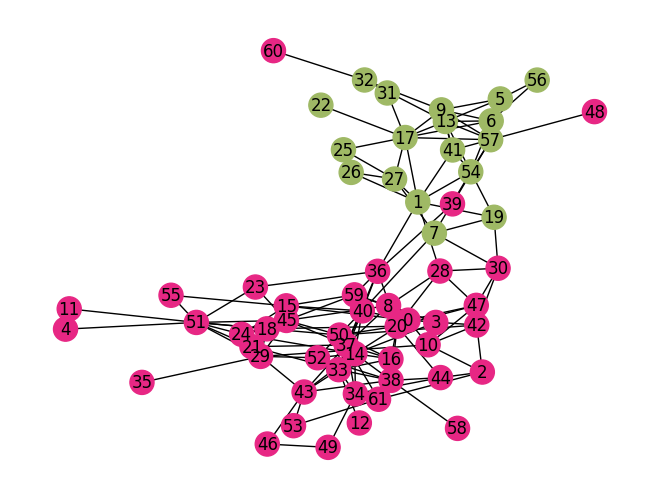

In [45]:
print_graph(G, result["communities"], nodes)